In [1]:
"""
This file is for providing functions to extract relevant features from the data.

Dealing with all datatypes:
    dropping irrelevant features
Dealing with numerics:
    change zero values by:
        dropping rows with zeros in it
        replacing zeros with median
    scaling numeric values like:
        log scale
        box cox scale
        absolute value negative values
    binning values
    removing outliers with Z-score threshold
    standard scale numeric values

Dealing with datetime:
    convert datetime to days from first date

Dealing with categories:
    replace NaN with the most common category
    reduce dimensions of categorical data
    convert categories into one-hot encoding

=======================================================================

Usage Examples:

>>> train_X, valid_X, train_y, valid_y = fe.get_data(
    '../data/train.csv', '../data/train_labels.csv')
>>> trans = fe.DataCleaning()
>>> transformed_train_X = trans.transform(train_X)
>>> np_train_X = fe.transform_df(transformed_train_X)

=======================================================================

Feature Engineering Descriptions:

Numeric:
Binarization: turn data into binary data.
Weight Changes: instead of linear weights, we can have polynomial weights.
Binning: put numeric values into bins, especially useful for inputs that have outliers or large ranges
    fixed binning: decide on the bin sizes myself
    adaptive binning (usually safer): can divide bins into quartiles 
Numeric Transformations: 
    log: best used for skewed distributions as it tends to expand the values that fall in the range of lower magnitudes and compress the range of higher magnitudes
    box cox: used when variabity in different regions are largely different
    arcsin: for porportions
Outlier Removals:
    z-score: parametric, usually 2.5, 3, 3.5
    Dbscan:  https://towardsdatascience.com/a-brief-overview-of-outlier-detection-techniques-1e0b2c19e561
    Isolation Forest:
Dealing With Irregular Values:
    replace by mean or median: problem is that it doesn't account for uncertainty in imputations and doesn't factor in correlations between features
feature combination:
    is there a way to combine features to make more insight? I don't see any reason right now.

Categorical:
If there's order, we can convert the categories into integers.
If there's no order, use one hot encoding.
If there's too many labels, group them into bins or use dimension reduction.
If there's irregular labels:
    replace by most frequent: problem is that it introduces biases
If there's missing values:
    replace by most common.
    Note that this is very tricky, and I really need to compare before and afters for training to see if this works.
"""


import json
import pprint
import warnings 
warnings.filterwarnings('ignore')

import numpy as np
import scipy.stats as ss
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin

import condense_csv


#======================================================================
# Get the data.
#======================================================================


def convert_num_labels_to_cat(df, categories):
    """
    Some columns have integer values, but do not denote any order, 
    so we need to convert them into categories.

    :param df: dataframe
    :type  df: pandas.core.frame.DataFrame
    :param categories: list of column names to convert
    :type  categories: list
    """

    for cat in categories:
        df[cat] = df[cat].astype('category')

    return df


def get_data(data_path, label_path, valid_size=0.2):
    """
    Get the data, and split it into train and validation.
    Also, convert appropriate numeric labels to categorical dtypes.

    :param data_path: path of the data input
    :type  data_path: str
    :param label_path: path of the data label
    :type  label_path: str
    :param test_size: Proportion to split on for the validation size
    :type  test_size: float
    """

    from sklearn.model_selection import train_test_split

    data = pd.read_csv(data_path)
    labels = pd.read_csv(label_path)
    data = condense_csv.compress_X(data)
    labels = condense_csv.compress_labels(labels)

    X_train, X_valid, y_train, y_valid = train_test_split(
        data,
        labels,
        test_size=valid_size,
        random_state=42
    )

    X_train = convert_num_labels_to_cat(
        X_train, ['region_code', 'district_code'])
    
    X_valid = convert_num_labels_to_cat(
        X_valid, ['region_code', 'district_code'])
    
    X_train['status_group'] = y_train['status_group']
    X_valid['status_group'] = y_valid['status_group']
    
    return X_train, X_valid, y_train, y_valid


#======================================================================
# Create a list of classes based on json file.
#======================================================================


def get_starting_info():
    """
    Get the initial starting information from starting_info.json.

    :returns: a dictionary where the key is the column name and 
              the value is a list, where the first item of that list
              is a list of operations to perform on the column 
              and the second item is a string that justifies why 
              a certain operation is performed.
    :rtype:   dict
    """

    file = open('../preprocess/starting_info.json')
    starting_info = json.load(file)
    file.close()
    return starting_info


class ColumnOperations:
    """
    A class for representing column operations to be performed for the dataframe
    """
    
    def __init__(self, name, operations, justifications):
        """
        :param name: column name
        :type  name: str
        :param operations: a sequence of operations to be performed on the column
        :type  operations: list
        :param justification: justification for operation
        :type  justification: str
        """
        
        self.name = name
        self.operations = operations
        self.justifications = justifications


def create_col_instances():
    """
    Create a list of instances of the column operation class

    :param col_dict: dictionary where keys are column names and values are the class attributes
    :type  col_dict: dict
    :returns: list of class instances
    :rtype:   list
    """

    starting_info = get_starting_info()

    col_instances = []
    for col_name, attributes in starting_info.items():
        col_instances.append(ColumnOperations(
            col_name, attributes[0], attributes[1]))
    return col_instances

list_of_classes = create_col_instances()


#======================================================================
# Perform operations on the dataframe.
#======================================================================


def perform_operations(df, col_name, operations):
    """
    Execute operations on a certain column in the dataframe.
        Dtypes                  Operations:      Description:
        ALL                     drop             drop the entire column

        Numerics
                                log              perform log transformation on the column
                                box cox          perform box cox transformation on the column
                                drop0            drop all values with zeros in it
                                absneg           absolute value the negatives
                                median0          replace 0 with the median
                                binning_NUM      create NUM amount of bins
                                outlierZ_NUM     remove outliers with z score > NUM
                                shiftmin         subtract the columns by the minimum value

        Datetime
                                finddays         convert datetime to days since the first day

        Categorical/Object
                                cbinning_NUM     create bins where each bin must have occurences 
                                                 of NUM or higher
                                mostcommon       replace nan with most common category

    :param df: dataframe 
    :type  df: pandas.core.frame.DataFrame
    :param col_name: name of column
    :type  col_name: str
    :param operations: list of operations to perform on the certain column
    :type  operations: list
    :returns: transformed dataframe 
    :rtype:   pandas.core.frame.DataFrame
    """

    col = df[col_name]

    # iterate throughout the list of transformations for each column
    for operation in operations:
        if operation == 'drop':
            # immediately returns the dataframe since no more operations can be
            # performed on a drop column
            return df.drop(col_name, axis=1)

        # numeric columns
        elif str(col.dtype) in {'int8', 'int16', 'int32', 'float64'}:
            if operation == 'log':
                col = np.log(1 + col)  # to make sure no divide by zero
            elif operation == 'box cox':
                col = ss.boxcox(col + 0.001)  # to make sure no divide by zero
            elif operation == "drop0":
                df = df[col != 0]
                col = col[col != 0]
            elif operation == "absneg":
                col = col.abs()
            elif operation == "median0":
                from sklearn.preprocessing import Imputer
                col[col == 0] = np.nan
                imputer = Imputer(strategy="median")
                col = imputer.fit_transform(col.values.reshape(-1, 1))
            elif operation.split('_')[0] == 'binning':
                # name would be binning_NUM
                num = int(operation.split('_')[1])
                quantile_list = [i / (num - 1) for i in range(num)]
                # this column with DROP_ will eventually be dropped.
                # It is here if one were to reference the the bins
                df["DROP_" + col_name] = pd.qcut(
                    col,
                    q=quantile_list,
                    duplicates='raise',
                )
                col = pd.qcut(
                    col,
                    q=quantile_list,
                    duplicates='raise',
                    labels=quantile_list[1:]
                )
            elif operation.split('_')[0] == 'outlierZ':
                z = np.abs(ss.zscore(col))
                keep_values = z < float(operation.split('_')[1])
                df = df[keep_values]
                col = col[keep_values]
            elif operation == "shiftmin":
                col = col - col.min()
            else:
                raise ValueError('Not an available operation for numerics')

        # datetime columns
        elif str(col.dtype) in {'datetime64[ns]'}:
            # TODO: add more datetime dtypes (not sure if that is the only one)
            if operation == "finddays":
                col = (col - min(col)).dt.days

        # categorical or object columns
        elif str(col.dtype) in {'category', 'object'}:
            if operation.split('_')[0] == "cbinning":
                num = float(operation.split('_')[1])
                value_counts = col.value_counts()
                x = col.replace(value_counts)
                df[col_name][df[col_name] == '0'] = np.nan
                df[col_name] = df[col_name].cat.add_categories(['OTHER'])
                df[col_name] = df[col_name].fillna('OTHER')
                df.loc[x < num, col_name] = 'OTHER'
                return df
            elif operation == "mostcommon":
                most_common = col.value_counts().index[0]
                col = col.fillna(most_common)
            else:
                raise ValueError(
                    'Not an available operation for categoricals or objects')

        else:
            raise ValueError('Not an available data type')

    df[col_name] = col

    return df


def perform_operations_with_classes(df, list_of_instances):
    """
    For each instance of a class in a list,
    perform the operation(s) indicated in the instance.
    For example, one instance contains the name of the column and 
    list of operations to perform on that column.
    For each matching column in the dataframe, perform the operations.

    :param df: dataframe
    :type  df: pandas.core.frame.DataFrame
    :param list_of_instances: list of instances of a class
    :type  list_of_instances: list
    :returns: dataframe
    :rtype:   pandas.core.frame.DataFrame
    """

    for col_class in list_of_instances:
        df = perform_operations(df, col_class.name, col_class.operations)
    return df


def drop_col_with_DROP(df):
    """
    Drop columns that have a name of DROP_XXX.
    
    :param df: dataframe
    :type  df: pandas.core.frame.DataFrame
    :returns: dataframe of dropped columns
    :rtype:   pandas.core.frame.DataFrame
    """
    
    for col in df.columns:
        if col.split('_')[0] == 'DROP':
            df = df.drop([col], axis=1)
    return df


class DataCleaning(BaseEstimator, TransformerMixin):
    """
    Class for performing data cleaning, so the same can be applied to the test case
    """

    def __init__(self, class_list=list_of_classes):
        """
        :param class_list: list of instances of the ColumnOperations class
        :type  class_list: list
        """

        self.class_list = class_list

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # drop all columns that has DROP_ in its column name
        X = drop_col_with_DROP(X)
        # use the list of classes and perform operations on each column based on the classes
        X_transformed = perform_operations_with_classes(X, self.class_list)
        return X_transformed


#======================================================================
# Create pipeline for standard scalar and one hot encoding.
#======================================================================


def split_cat_num(df):
    """
    Split the dataframe into two dataframes, 
    where one contains the numeric datatypes 
    and the other contains categorical datatypes.

    :param df: dataframe
    :type  df: pandas.core.frame.DataFrame
    :returns: (df with numeric dtypes, df with categorical dtypes)
    :rtype:   (pandas.core.frame.DataFrame, pandas.core.frame.DataFrame)
    """

    col_names = set(df.columns)
    types = set([str(dtype) for dtype in df.dtypes.values])

    num_cols = df.select_dtypes(
        include=['int8', 'int16', 'int32', 'int64', 'float64'])
    cat_cols = df.select_dtypes(include=['category'])

    num_col_names = set(num_cols.columns)
    cat_col_names = set(cat_cols.columns)

    missing_col_names = col_names.difference(
        num_col_names).difference(cat_col_names)

    if len(missing_col_names) != 0:
        print("Columns Missing:", missing_col_names)

    return num_cols, cat_cols

def transform_df(df, cat_encode_type):
    """
    :param df: dataframe
    :type  df: pandas.core.frame.DataFrame
    :param cat_encode_type: The type of encoding (one hot or just label)
    :type  cat_encode_type: str 
    :returns: numpy array of size (instances, 
              number of numeric columns + category one hot encoded columns)
    :rtype:   numpy.ndarray
    """

    from sklearn.pipeline import Pipeline
    from sklearn.preprocessing import StandardScaler
    from sklearn.compose import ColumnTransformer

    num_cols, cat_cols = split_cat_num(df)
    num_col_names = list(num_cols.columns)
    cat_col_names = list(cat_cols.columns)

    num_pipeline = Pipeline([
        ('std_scaler', StandardScaler()),
    ])
    
    if cat_encode_type == "one hot":
        # one hot encoded: a lot more columns
        from sklearn.preprocessing import OneHotEncoder
        full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_col_names),
        ("cat", OneHotEncoder(), cat_col_names),
        ])
        result = full_pipeline.fit_transform(df).toarray()
        
    elif cat_encode_type == "numeric":
        num_col = num_pipeline.fit_transform(num_cols.values)
        cat_encoded = cat_cols.apply(lambda x: x.cat.codes)
        cat_encoded = cat_encoded.reset_index(drop=True)
        num_col = pd.DataFrame(data=num_col, columns=num_col_names)
        result = pd.concat([num_col, cat_encoded], axis=1)
    else:
        raise ValueError("Not an available encoder type")

    return result

In [2]:
pd.set_option('display.max_columns', 100)

In [3]:
train_X, valid_X, train_y, valid_y = get_data(
    '../data/train.csv', '../data/train_labels.csv')

memory used before preprocess:  19.00808

date time size before: 3.9798799999999996
date time size after:  0.47528 

converting funder                         size:  3.86	->	 0.33
converting installer                      size:  3.64	->	 0.34
converting basin                          size:  4.03	->	 0.06
converting subvillage                     size:  3.85	->	 2.03
converting region                         size:  3.78	->	 0.06
converting lga                            size:  3.83	->	 0.07
converting ward                           size:  3.83	->	 0.34
converting public_meeting                 size:  2.1	->	 0.06
converting recorded_by                    size:  4.75	->	 0.06
converting scheme_management              size:  3.55	->	 0.06
converting scheme_name                    size:  3.15	->	 0.4
converting permit                         size:  2.06	->	 0.06
converting extraction_type                size:  3.84	->	 0.06
converting extraction_type_group          size:  3.85	->	 0.06
con

In [4]:
train_X.head()

id  amount_tsh date_recorded funder  gps_height installer  \
3607     454        50.0    2013-02-27   Dmdd        2092      DMDD   
50870    510         0.0    2011-03-17   Cmsr           0      Gove   
20413  14146         0.0    2011-07-10   Kkkt           0      KKKT   
52806  47410         0.0    2011-04-12    NaN           0       NaN   
50091   1288       300.0    2011-04-05     Ki        1023        Ki   

       longitude  latitude                 wpt_name  num_private        basin  \
3607   35.426020 -4.227446                    Narmo            0     Internal   
50870  35.510074 -5.724555                   Lukali            0     Internal   
20413  32.499866 -9.081222                 Mahakama            0   Lake Rukwa   
52806  34.060484 -8.830208  Shule Ya Msingi Chosi A            0       Rufiji   
50091  37.032690 -6.040787                Kwa Mjowe            0  Wami / Ruvu   

         subvillage    region region_code district_code      lga      ward  \
3607   Bashnet Kati   Manyara          21             1   Babati  Bashinet   
50870        Lukali    Dodoma           1             6     Bahi   Lamaiti   
20413   Chawalikozi     Mbeya          12             6    Mbozi  Ndalambo   
52806       Shuleni     Mbeya          12             7  Mbarali   Chimala   
50091      Ngholong  Morogoro           5             1   Kilosa  Chakwale   

       population public_meeting              recorded_by scheme_management  \
3607          160           True  GeoData Consultants Ltd       Water Board   
50870           0           True  GeoData Consultants Ltd               VWC   
20413           0           True  GeoData Consultants Ltd               VWC   
52806           0           True  GeoData Consultants Ltd               VWC   
50091         120           True  GeoData Consultants Ltd               VWC   

      scheme_name permit  construction_year extraction_type  \
3607          NaN   True               1998         gravity   
50870         NaN   True                  0   india mark ii   
20413         NaN  False                  0           other   
52806         NaN   True                  0         gravity   
50091         NaN   True               1997           other   

      extraction_type_group extraction_type_class   management  \
3607                gravity               gravity  water board   
50870         india mark ii              handpump          vwc   
20413                 other                 other          vwc   
52806               gravity               gravity          vwc   
50091                 other                 other          vwc   

      management_group                payment payment_type water_quality  \
3607        user-group         pay per bucket   per bucket          soft   
50870       user-group              never pay    never pay          soft   
20413       user-group              never pay    never pay          soft   
52806       user-group            pay monthly      monthly          soft   
50091       user-group  pay when scheme fails   on failure         salty   

      quality_group      quantity quantity_group        source   source_type  \
3607           good  insufficient   insufficient        spring        spring   
50870          good        enough         enough  shallow well  shallow well   
20413          good        enough         enough  shallow well  shallow well   
52806          good  insufficient   insufficient         river    river/lake   
50091         salty        enough         enough  shallow well  shallow well   

      source_class     waterpoint_type waterpoint_type_group    status_group  
3607   groundwater  communal standpipe    communal standpipe      functional  
50870  groundwater           hand pump             hand pump      functional  
20413  groundwater               other                 other  non functional  
52806      surface  communal standpipe    communal standpipe  non functional  
50091  groundwater               other     

# Training

In [5]:
trans = DataCleaning()
transformed_train_X = trans.transform(train_X)

/Users/jinli/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [6]:
transformed_train_X.head()

amount_tsh  date_recorded funder  gps_height installer  longitude  \
3607     3.931826           3339   Dmdd        2092     OTHER  35.426020   
50870    0.000000           2626  OTHER           0      Gove  35.510074   
20413    0.000000           2741   Kkkt           0      KKKT  32.499866   
52806    0.000000           2652  OTHER           0     OTHER  34.060484   
50091    5.707110           2645     Ki        1023     OTHER  37.032690   

       latitude    region district_code  population public_meeting  \
3607  -4.227446   Manyara             1         160           True   
50870 -5.724555    Dodoma             6           0           True   
20413 -9.081222     Mbeya             6           0           True   
52806 -8.830208     Mbeya             7           0           True   
50091 -6.040787  Morogoro             1         120           True   

      scheme_management permit  construction_year extraction_type_class  \
3607        Water Board   True               38.0               gravity   
50870               VWC   True               40.0              handpump   
20413               VWC  False               40.0                 other   
52806               VWC   True               40.0               gravity   
50091               VWC   True               37.0                 other   

        management payment_type quality_group quantity_group        source  \
3607   water board   per bucket          good   insufficient        spring   
50870          vwc    never pay          good         enough  shallow well   
20413          vwc    never pay          good         enough  shallow well   
52806          vwc      monthly          good   insufficient         river   
50091          vwc   on failure         salty         enough  shallow well   

      waterpoint_type_group    status_group  
3607     communal standpipe      functional  
50870             hand pump      functional  
20413                 other  non functional  
52806    communal standpipe  non functional  
50091                 other  non functional

In [7]:
train_y = transformed_train_X['status_group']
transformed_train_X.drop(['status_group'], axis=1, inplace=True)

In [8]:
np_train_X = transform_df(transformed_train_X, cat_encode_type="numeric")
np_train_X.shape

(45517, 21)

In [9]:
type (train_y)

pandas.core.series.Series

In [10]:
def encode_labels(labels, convert_type):
    """
    Convert labels into numeric labels (either numeric or one hot)
    
    :param labels: a series of the labels
    :type  labels: pandas.core.series.Series
    :param labels: type of conversion
    :type  labels: str
    """

    labels = pd.DataFrame(train_y)
    if convert_type == "numeric":
        from sklearn.preprocessing import LabelEncoder
        encoder = LabelEncoder()
    elif convert_type == "one hot":
        from sklearn.preprocessing import OneHotEncoder
        encoder = OneHotEncoder()
    else:
        raise ValueError("Not an avaliable convert type")
        
    label_encoded = encoder.fit_transform(labels)
    return encoder, label_encoded

y_encoder, train_y_enc = encode_labels(train_y, convert_type="numeric")
train_y_enc#.toarray()

array([0, 0, 2, ..., 2, 0, 2])

In [11]:
%%time
"""
it is very important to note that xgb does not handle categorical data.
We can do either one hot encoding or convert categories to integer representation.
However, converting categories to integer representation may result in accidently 
ordering the categories when there should be no order.
On the other hand, onehot encoding would take a long time and produce many 
categories of 1/0, causing the tree algorithm to downplay the 1hot encoded features

Also, xgb handles missing values
"""
import xgboost as xgb
xgc = xgb.XGBClassifier(
    n_estimators=5,
    max_depth=5,
    base_score=0.5,
    # softmax loss function for class probabilities (we have 3 outputs)
    objective='multi:softprob', 
    random_state=42
)
xgc.fit(np_train_X, train_y_enc)
print (xgc)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=5,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
CPU times: user 1.59 s, sys: 31.4 ms, total: 1.62 s
Wall time: 1.65 s


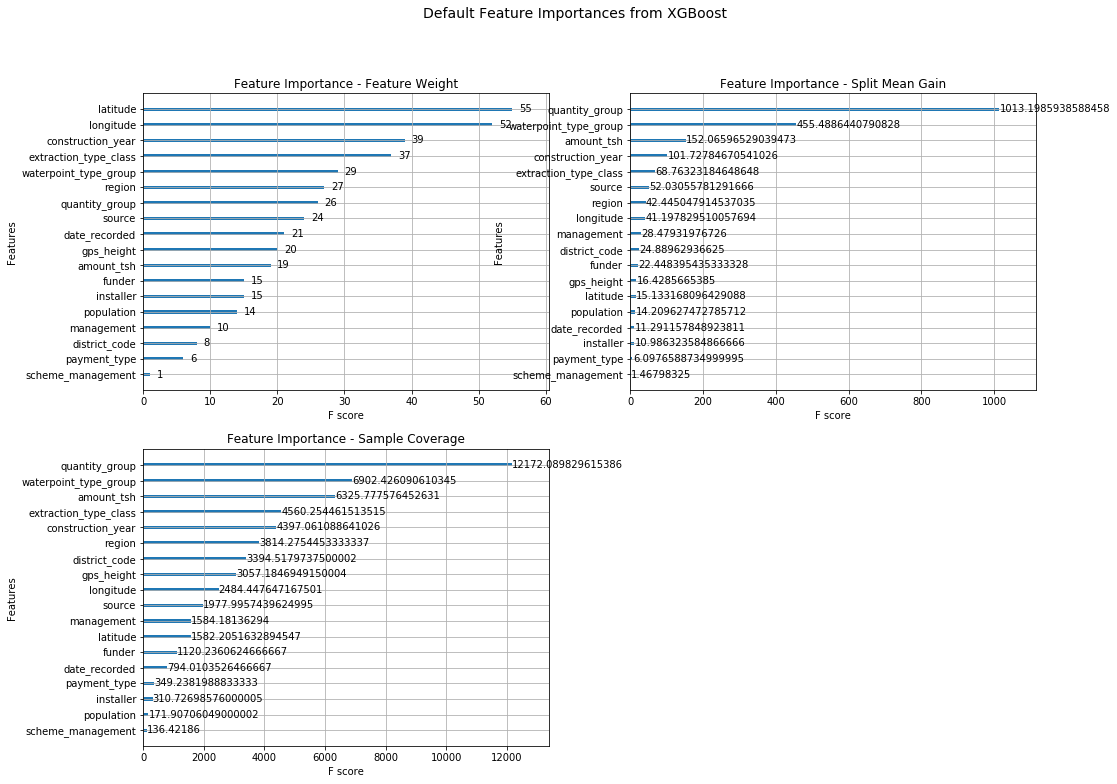

In [12]:
import matplotlib.pyplot as plt

def xgb_feature_importance(xgc):
    """
    Plot feature importance from the xgb model.
    Measures include: wieght, split mean gain, sample converage
    
    :param xgc: the trained model of xgb
    :type  xgc: xgboost.sklearn.XGBClassifier
    """
    
    fig = plt.figure(figsize = (16, 12))
    title = fig.suptitle("Default Feature Importances from XGBoost", fontsize=14)

    ax1 = fig.add_subplot(2,2, 1)
    xgb.plot_importance(xgc, importance_type='weight', ax=ax1)
    t=ax1.set_title("Feature Importance - Feature Weight")

    ax2 = fig.add_subplot(2,2, 2)
    xgb.plot_importance(xgc, importance_type='gain', ax=ax2)
    t=ax2.set_title("Feature Importance - Split Mean Gain")

    ax3 = fig.add_subplot(2,2, 3)
    xgb.plot_importance(xgc, importance_type='cover', ax=ax3)
    t=ax3.set_title("Feature Importance - Sample Coverage")
    plt.show()
    
xgb_feature_importance(xgc)

In [13]:
import eli5
# show how influential each feature is to the final prediction
eli5.show_weights(xgc.get_booster())

# Test Accuracy

In [14]:
#valid_X['status_group'] = valid_y['status_group']
transformed_valid_X = trans.transform(valid_X)

/Users/jinli/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [15]:
transformed_valid_X.head()

amount_tsh  date_recorded funder  gps_height installer  longitude  \
2980     0.000000           3648  OTHER           0       DWE  31.985658   
5246     0.000000           3673  OTHER           0     OTHER  32.832815   
22659    2.397895           3787  OTHER        1675       DWE  35.488289   
39888    0.000000           3225   Kkkt           0      KKKT  33.140828   
13361    3.931826           3770  OTHER        1109     OTHER  34.217077   

       latitude     region district_code  population public_meeting  \
2980  -3.596360  Shinyanga             5           0           True   
5246  -4.944937     Tabora             6           0           True   
22659 -4.242048    Manyara             1         148           True   
39888 -9.059386      Mbeya             6           0          False   
13361 -4.430529    Singida             1         235           True   

      scheme_management permit  construction_year extraction_type_class  \
2980                WUG   True               40.0                 other   
5246                VWC   True               40.0              handpump   
22659       Water Board   True               48.0               gravity   
39888               VWC  False               40.0              handpump   
13361               WUA   True               51.0             motorpump   

        management payment_type quality_group quantity_group        source  \
2980           wug      unknown          good            dry  shallow well   
5246           vwc    never pay         milky   insufficient  shallow well   
22659  water board   per bucket          good   insufficient        spring   
39888          vwc    never pay          good       seasonal  shallow well   
13361          wua   per bucket          good         enough   machine dbh   

      waterpoint_type_group    status_group  
2980                  other  non functional  
5246              hand pump      functional  
22659    communal standpipe      functional  
39888             hand pump  non functional  
13361    communal standpipe      functional

In [16]:
valid_y = transformed_valid_X['status_group']
transformed_valid_X.drop(['status_group'], axis=1, inplace=True)

In [17]:
np_valid_X = transform_df(transformed_valid_X, cat_encode_type="numeric")
np_valid_X.shape

(11367, 21)

In [18]:
valid_y_label = pd.DataFrame(valid_y)
valid_y_label_enc = y_encoder.fit_transform(valid_y_label)
valid_y_label_enc.shape

(11367,)

In [19]:
y_pred = xgc.predict(np_valid_X)

In [20]:
type (y_pred)

numpy.ndarray

In [21]:
def test_measure(answer, prediction, metric):
    """
    Use a metric to measure the success of the model
    
    :param answer: The label answer
    :type  answer: numpy.ndarray
    :param prediction: The predicted answer
    :type  prediction: numpy.ndarray
    :param answer: The metric used to evaluate the model
    :type  metric: str
    """
    
    if metric == "accuracy":
        from sklearn.metrics import accuracy_score
        accuracy = accuracy_score(answer, prediction)
        print("Accuracy: %.2f%%" % (accuracy * 100.0))
    else:
        raise ValueError("Not an avaliable metric")
        
test_measure(valid_y_label_enc, y_pred, metric="accuracy")

Accuracy: 71.59%


In [22]:
import random


def eli_instance(answer, prediction, label_value, match=False):

    """
    Get an index where the label is a certain value
    
    :param answer: the numpy array of the label answers
    :type  answer: numpy.ndarray 
    :param prediction: the numpy array of the label predictions
    :type  prediction: numpy.ndarray 
    :param label_value: the prediction value
    :type  label_value: int
    :param match: whether the prediction and answer matches or not
    :type  match: bool
    :returns: index of one of the label
    :rtype:   num
    """
    
    if match:
        in_pred_and_actual = np.logical_and (answer == label_value, prediction == label_value)
        index = np.where(in_pred_and_actual)[0]
    else:
        index = np.where(answer == label_value)[0]
    doc_num = random.choice(index)

    print('Actual Label:', answer[doc_num])
    print('Predicted Label:', prediction[doc_num])

    return doc_num


doc_num_0 = eli_instance(valid_y_label_enc, y_pred, label_value=0, match=True)
doc_num_1 = eli_instance(valid_y_label_enc, y_pred, label_value=1, match=True)
doc_num_2 = eli_instance(valid_y_label_enc, y_pred, label_value=2, match=True)

Actual Label: 0
Predicted Label: 0
Actual Label: 1
Predicted Label: 1
Actual Label: 2
Predicted Label: 2


In [23]:
eli5.show_prediction(
    xgc.get_booster(), 
    np_valid_X.iloc[doc_num_0],
    feature_names=list(transformed_valid_X.columns),
    show_feature_values=True
)

In [24]:
eli5.show_prediction(
    xgc.get_booster(), 
    np_valid_X.iloc[doc_num_1],
    feature_names=list(transformed_valid_X.columns),
    show_feature_values=True
)

In [25]:
eli5.show_prediction(
    xgc.get_booster(), 
    np_valid_X.iloc[doc_num_2],
    feature_names=list(transformed_valid_X.columns),
    show_feature_values=True
)

In [26]:
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel

"""
the more a model’s decision criteria depend on a feature,
the more we’ll see predictions change as a function of perturbing a feature
"""

interpreter = Interpretation(
    training_data=np_valid_X,
    training_labels=valid_y_label_enc,
    feature_names=list(transformed_valid_X.columns)
)

im_model = InMemoryModel(
    xgc.predict_proba,
    examples=np_train_X,
    target_names=['0', '1', '2']
)

2019-01-08 16:50:50,335 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progress_bar=False


[21/21] features ████████████████████ Time elapsed: 13 seconds

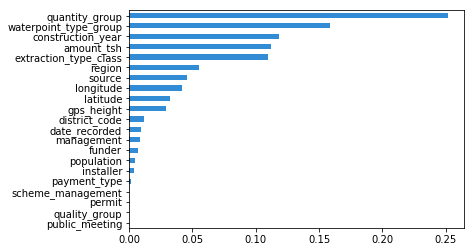

In [27]:
%matplotlib inline 
plots = interpreter.feature_importance.plot_feature_importance(
    im_model,
    ascending=True,
    n_samples=23000,
)

2019-01-08 17:00:47,545 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progressbar=False


[2500/2500] grid cells ████████████████████ Time elapsed: 1347 seconds

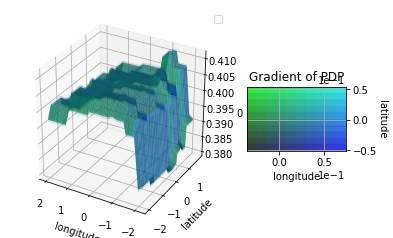

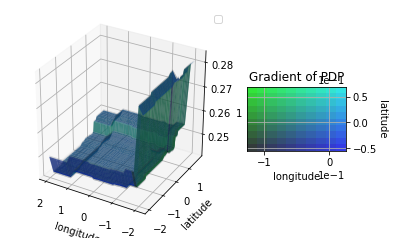

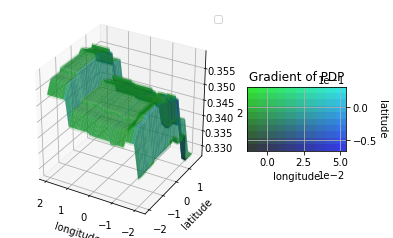

In [34]:
"""
Describes the marginal impact of a feature on model prediction,
assuming all other features are constant.
"""

"""
the axis is awkward since I used standard scaler
I guess the axis should just be ignored
"""
r = interpreter.partial_dependence.plot_partial_dependence(
    #[('longitude', 'latitude')],
    ['longitude']
    im_model,
    grid_resolution=50,
    grid_range=(0, 1),
    n_samples=23000,
    with_variance=True,
    figsize=(6, 4)
)
##yl = r[0][1].set_ylim(0, 1)

2019-01-08 16:53:08,591 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progressbar=False


[5/5] grid cells ████████████████████ Time elapsed: 1 seconds

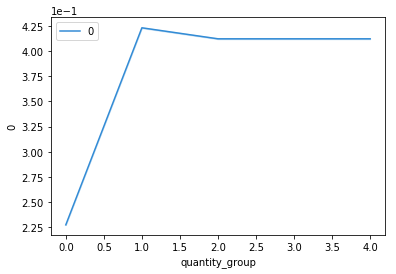

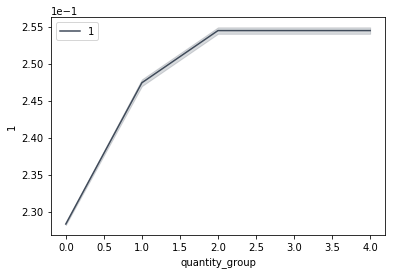

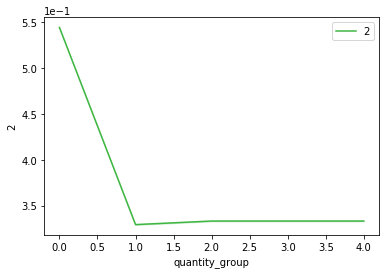

In [29]:
# note that in this case, the column is categorical, so a line plot doesn't entirely make sense
r = interpreter.partial_dependence.plot_partial_dependence(
    ['quantity_group'],
    im_model,
    grid_resolution=50,
    grid_range=(0, 1),
    n_samples=23000,
    with_variance=True,
    figsize=(6, 4)
)

In [38]:
#np_valid_X#.values

In [58]:


xgc_np = xgb.XGBClassifier(n_estimators=5, max_depth=5, base_score=0.5,
                           objective='binary:logistic', random_state=42)
xgc_np.fit(np_train_X.values, train_y_enc)

from skater.core.local_interpretation.lime.lime_tabular import LimeTabularExplainer

exp = LimeTabularExplainer(
    np_valid_X.values,
    feature_names=list(transformed_valid_X.columns),
    discretize_continuous=True,
    class_names=['0', '1', '2']
)

In [61]:
exp.explain_instance(np_valid_X.iloc[doc_num_0], xgc_np.predict_proba).show_in_notebook()

In [60]:
exp.explain_instance(np_valid_X.iloc[doc_num_1], xgc_np.predict_proba).show_in_notebook()

In [62]:
exp.explain_instance(np_valid_X.iloc[doc_num_2], xgc_np.predict_proba).show_in_notebook()

In [68]:
import shap
explainer = shap.TreeExplainer(xgc)
shap_values = explainer.shap_values(np_valid_X)
print('Expected Value:', explainer.expected_value)
#pd.DataFrame(shap_values).head()

Expected Value: [0.69834316, 0.2268638, 0.55218977]


In [75]:
shap_values[0].shape#.shape

(11367, 21)

In [104]:
# need to run this 
#!jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10
# shap.force_plot(
#     explainer.expected_value[0],
#     shap_values[0],
#     np_valid_X.iloc[2,:].values
# )

In [80]:
#np_valid_X

In [84]:
np_valid_X.iloc[2,:]

amount_tsh                  0.279113
date_recorded               0.997763
gps_height                  1.423466
longitude                   0.136334
latitude                    0.589626
population                 -0.005134
construction_year           0.989668
funder                   1897.000000
installer                 390.000000
region                      8.000000
district_code               1.000000
public_meeting              1.000000
scheme_management          10.000000
permit                      1.000000
extraction_type_class       0.000000
management                  9.000000
payment_type                5.000000
quality_group               2.000000
quantity_group              2.000000
source                      8.000000
waterpoint_type_group       1.000000
Name: 2, dtype: float64

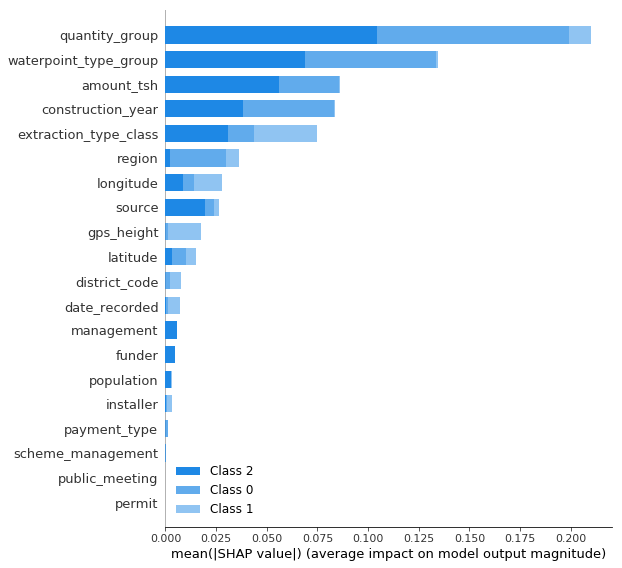

In [87]:
shap.summary_plot(shap_values, 
                  np_valid_X, plot_type="bar")

In [98]:
# shap.dependence_plot(
#     ind='population',
#     interaction_index='population',
#     shap_values=shap_values,
#     #features=np_valid_X.columns,
#     #display_features=np_valid_X
# )
shap.dependence_plot(
    'population',
    shap_values,
    np_valid_X.values
    #features=np_valid_X.columns,
    #display_features=np_valid_X
)

AttributeError: 'list' object has no attribute 'shape'

In [99]:
X,y = shap.datasets.boston()

In [100]:
X

CRIM    ZN  INDUS  CHAS    NOX     RM    AGE     DIS   RAD    TAX  \
0     0.00632  18.0   2.31   0.0  0.538  6.575   65.2  4.0900   1.0  296.0   
1     0.02731   0.0   7.07   0.0  0.469  6.421   78.9  4.9671   2.0  242.0   
2     0.02729   0.0   7.07   0.0  0.469  7.185   61.1  4.9671   2.0  242.0   
3     0.03237   0.0   2.18   0.0  0.458  6.998   45.8  6.0622   3.0  222.0   
4     0.06905   0.0   2.18   0.0  0.458  7.147   54.2  6.0622   3.0  222.0   
5     0.02985   0.0   2.18   0.0  0.458  6.430   58.7  6.0622   3.0  222.0   
6     0.08829  12.5   7.87   0.0  0.524  6.012   66.6  5.5605   5.0  311.0   
7     0.14455  12.5   7.87   0.0  0.524  6.172   96.1  5.9505   5.0  311.0   
8     0.21124  12.5   7.87   0.0  0.524  5.631  100.0  6.0821   5.0  311.0   
9     0.17004  12.5   7.87   0.0  0.524  6.004   85.9  6.5921   5.0  311.0   
10    0.22489  12.5   7.87   0.0  0.524  6.377   94.3  6.3467   5.0  311.0   
11    0.11747  12.5   7.87   0.0  0.524  6.009   82.9  6.2267   5.0  311.0   
12    0.09378  12.5   7.87   0.0  0.524  5.889   39.0  5.4509   5.0  311.0   
13    0.62976   0.0   8.14   0.0  0.538  5.949   61.8  4.7075   4.0  307.0   
14    0.63796   0.0   8.14   0.0  0.538  6.096   84.5  4.4619   4.0  307.0   
15    0.62739   0.0   8.14   0.0  0.538  5.834   56.5  4.4986   4.0  307.0   
16    1.05393   0.0   8.14   0.0  0.538  5.935   29.3  4.4986   4.0  307.0   
17    0.78420   0.0   8.14   0.0  0.538  5.990   81.7  4.2579   4.0  307.0   
18    0.80271   0.0   8.14   0.0  0.538  5.456   36.6  3.7965   4.0  307.0   
19    0.72580   0.0   8.14   0.0  0.538  5.727   69.5  3.7965   4.0  307.0   
20    1.25179   0.0   8.14   0.0  0.538  5.570   98.1  3.7979   4.0  307.0   
21    0.85204   0.0   8.14   0.0  0.538  5.965   89.2  4.0123   4.0  307.0   
22    1.23247   0.0   8.14   0.0  0.538  6.142   91.7  3.9769   4.0  307.0   
23    0.98843   0.0   8.14   0.0  0.538  5.813  100.0  4.0952   4.0  307.0   
24    0.75026   0.0   8.14   0.0  0.538  5.924   94.1  4.3996   4.0  307.0   
25    0.84054   0.0   8.14   0.0  0.538  5.599   85.7  4.4546   4.0  307.0   
26    0.67191   0.0   8.14   0.0  0.538  5.813   90.3  4.6820   4.0  307.0   
27    0.95577   0.0   8.14   0.0  0.538  6.047   88.8  4.4534   4.0  307.0   
28    0.77299   0.0   8.14   0.0  0.538  6.495   94.4  4.4547   4.0  307.0   
29    1.00245   0.0   8.14   0.0  0.538  6.674   87.3  4.2390   4.0  307.0   
..        ...   ...    ...   ...    ...    ...    ...     ...   ...    ...   
476   4.87141   0.0  18.10   0.0  0.614  6.484   93.6  2.3053  24.0  666.0   
477  15.02340   0.0  18.10   0.0  0.614  5.304   97.3  2.1007  24.0  666.0   
478  10.23300   0.0  18.10   0.0  0.614  6.185   96.7  2.1705  24.0  666.0   
479  14.33370   0.0  18.10   0.0  0.614  6.229   88.0  1.9512  24.0  666.0   
480   5.82401   0.0  18.10   0.0  0.532  6.242   64.7  3.4242  24.0  666.0   
481   5.70818   0.0  18.10   0.0  0.532  6.750   74.9  3.3317  24.0  666.0   
482   5.73116   0.0  18.10   0.0  0.532  7.061   77.0  3.4106  24.0  666.0   
483   2.81838   0.0  18.10   0.0  0.532  5.762   40.3  4.0983  24.0  666.0   
484   2.37857   0.0  18.10   0.0  0.583  5.871   41.9  3.7240  24.0  666.0   
485   3.67367   0.0  18.10   0.0  0.583  6.312   51.9  3.9917  24.0  666.0   
486   5.69175   0.0  18.10   0.0  0.583  6.114   79.8  3.5459  24.0  666.0   
487   4.83567   0.0  18.10   0.0  0.583  5.905   53.2  3.1523  24.0  666.0   
488   0.15086   0.0  27.74   0.0  0.609  5.454   92.7  1.8209   4.0  711.0   
489   0.18337   0.0  27.74   0.0  0.609  5.414   98.3  1.7554   4.0  711.0   
490   0.20746   0.0  27.74   0.0  0.609  5.093   98.0  1.8226   4.0  711.0   
491   0.10574   0.0  27.74   0.0  0.609  5.983   98.8  1.8681   4.0  711.0   
492   0.11132   0.0  27.74   0.0  0.609  5.983   83.5  2.1099   4.0  711.0   
493   0.17331   0.0   9.69   0.0  0.585  5.707   54.0  2.3817   6.0  391.0   
494   0.27957   0.0   9.69   0.0  0.585  5.926   42.6  2.3817   6.0  391.0   
495   0.17899   0.0   9.69   0.